# Crypto Semantic Search

This example demonstrates how to use kdbai to ask questions and get information from two types of data: structured crypto price data and unstructured Twitter data.

By conducting semantic similarity searches, we can analyze how crypto prices change after certain tweets, helping to identify which tweets are potentially more profitable to act upon and which ones may be riskier.

<center><img src="crypto.png"/></center>

## What is Semantic Search?

Semantic search allows users to perform searches based on the meaning or similarity of the data rather than exact matches. It works by converting the query into a vector representation and then finding similar vectors in the database. This way, even if the query and the data in the database are not identical, the system can identify and retrieve the most relevant results based on their semantic meaning.


## Aim

We combine Twitter data and crypto price data, and then use semantic search to analyze the relationship between them. By looking for correlations, we determine if there is a connection between tweets and the changes in cryptocurrency prices. This helps us understand how public opinions on social media may influence the crypto market.

<center><img src="crypto_semantic.png"/></center>

The steps to do this are:
1. Importing Libraries 
1. Load Data
1. Create KDB.ai Index
1. Semantic Search Queries
    1. Distribution of 30 min returns post tweet
    1. Plot of expected returns and volatility as various time horizons

## Importing Libraries

Start by importing the necessary libraries. We will be using the `kdbai` library to interact with KDB.ai.

In [1]:
## Uncomment this `pip install` command if you see import errors
# %pip install --quiet sentence_transformers wordcloud matplotlib scipy

In [1]:
import os
os.environ['PYKX_ENABLE_PANDAS_API'] = 'true'
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import kdbai
import pykx as kx
import scipy
from wordcloud import WordCloud, STOPWORDS
from sentence_transformers import SentenceTransformer

## Load Data

Next, we will load in the transformer model as well as both the twitter and the crypto price data and join them together.  

- Sentence transformer model `all-MiniLM-L6-v2` used to encode tweets to embedded vectors
- Dataset `vectors` of over 1M tweets with embedded vector representations
- Dataset `returns` with interval retruns from bitcoin over a range or horizons

### Load Transformer and Data

First, we load the datasets into memory from disk. The datasets `vectors` and `returns` are serialized tables we can load in as PyKX Tables.

<div class="alert alert-block alert-info">
    <b>New to PyKX?:</b> Above, we imported the <a href="https://code.kx.com/pykx/1.6/api/q/q.html">PyKX library</a> as kx. We use kx.q  to call PyKX functions from Python and to generate PyKX objects.
</div>

In [2]:
model = SentenceTransformer('all-MiniLM-L6-v2')
vectors = kx.q.read.serialized('/opt/kx/data/vectors')
returns = kx.q.read.serialized('/opt/kx/data/returns')

### Merge Dataset

Next, we want to merge the Twitter data and the crypto price data based on the date, and combine them into a single dataset. We can do this using:
- [xasc](https://code.kx.com/pykx/1.6/api/q/q.html#xasc) to sort the data in ascending order by date
- [merge_asof](https://code.kx.com/pykx/1.6/user-guide/advanced/Pandas_API.html#tablemerge_asof) to perform an as-of join on date

In [3]:
vectors = kx.q.xasc('date',vectors)
data = vectors.merge_asof(returns,on="date")

### Filter Data

Next, we will filter to keep only the largest user followings, so those with more than 100 followers.

In [4]:
data = data[data['user_followers'] > 100]

### Add Vector Column 

Finally we add a column called `vector` which is simply a list of all feature columns grouped into one. We do this using :
- [qsql.update](https://code.kx.com/pykx/api/query.html#pykx.query.QSQL.update) to add column
- [enlist](https://code.kx.com/pykx/1.6/api/q/q.html#enlist) to return results as a list
- [flip](https://code.kx.com/pykx/1.6/api/q/q.html#flip) to transpose arguments

In [5]:
data = kx.q.qsql.update(data,columns={'vector':
                               kx.q.enlist( 
                               kx.q.flip((data[['feature_'+str(i) for i in range(384)]]).values()))})

## Create KDB.ai Index

Now, we are ready to build a IVFPQ index using KDB.ai with the merged table from the previous step. Here we generate an index which performs inverted file index with product quantization and add our dataset.

In [6]:
params = {'initData':data,'nclusters':10,'nsplits':32,'nbits':8}

index = kdbai.KDBAI("index_semantic",
                "ivfpq",
                ["table_semantic",None],
                "vector",
                params)

index.append(data)

Setting the table: '.kdbai.table.table_semantic' as a global table within this process

Updating index with new vector data
Updating in-memory table: '.kdbai.table.table_semantic' with new data


The `list` function is useful to return indexes available in your process. Once your index is created in the previous step, its details appears when running the below command.

In [7]:
index.list()

pykx.Dictionary(pykx.q('
              | name                        mdlType algo                     ..
--------------| -------------------------------------------------------------..
index_semantic| .kdbai.model.index_semantic ivfpq   `ptrs`add`search`filter`w..
'))

## Semantic Search Queries

Now, we are ready to query the index using the `search` operation to return similar vectors.

### Perform semantic search queries against dataset

We run two queries against the data

- BTC, we encode the text \"BTC\" as an embedded vector using our transformer model then we use the index to search for the 50000 nearest neighbors

- NFT, we encode the text \"NFT\" as an embedded vector using our transformer model then we use the index to search for the 50000 nearest neighbors

***This gives us two groups of tweets with associated price moves***

In [21]:
search1 = "BTC"
search2 = "NFT"

k = 50000

x = index.search(model.encode(search1).reshape(1,384),
                      kx.toq(["t1","t5","t15","t30","t60","text"]),
                      0,
                      {'neighbors':k,'clusters':1})

y = index.search(model.encode(search2).reshape(1,384),
                      kx.toq(["t1","t5","t15","t30","t60","text"]),
                      0,
                      {'neighbors':k,'clusters':1})

### Word cloud associate to each group of tweets

***To visualize the most frequent words in each group we plot two world clouds***

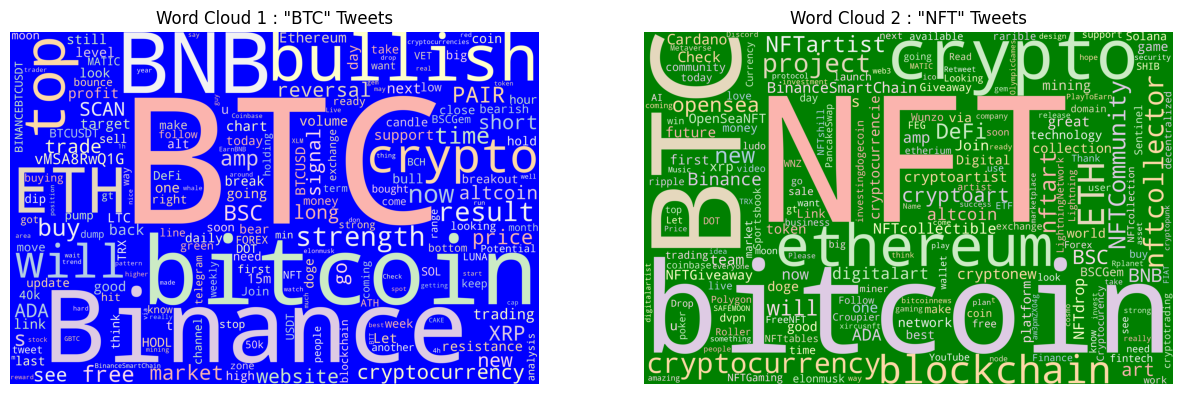

In [22]:
text_btc = ' '.join(x['text'].py())
text_nft = ' '.join(y['text'].py())
for s in ['$','#','!','?','.','-','\n',':','https//tco','Bitcoin']:
    text_nft = text_nft.replace(s,'')
    text_btc = text_btc.replace(s,'')
wc_btc = WordCloud(width= 3000, height = 2000, random_state=1, background_color='blue', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text_btc)
wc_nft = WordCloud(width= 3000, height = 2000, random_state=1, background_color='green', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text_nft)

fig,ax = plt.subplots(1,2,figsize=(15,6))
ax[0].imshow(wc_btc)
ax[1].imshow(wc_nft)
ax[0].axis("off")
ax[1].axis("off")
ax[0].set_title("Word Cloud 1 : \"BTC\" Tweets")
ax[1].set_title("Word Cloud 2 : \"NFT\" Tweets")
plt.show()

### Distribution of 30 min returns post tweet

We plot two histograms of the price moves following the BTC and NFT tweets. We can clearly see the distibution of returns following BTC tweets is more mesokurtic, while the distribution of returns post NFT tweet is platykurtic. In essence there are fatter tails in the BTC returns suggesting that these tweets are predictive of higher market volatility and risk. 

***The difference between the distributions of returns is statistically significant as described by the KS stat***

<div class="alert alert-block alert-info">
<b>What is KS stat?:</b> The KS stat, or Kolmogorov-Smirnov statistic, is like a measuring tool that helps us compare two sets of data to see if they are similar or different. If the gap is small, it means the two sets of data are quite similar. But if the gap is big, it means they are very different.
</div>


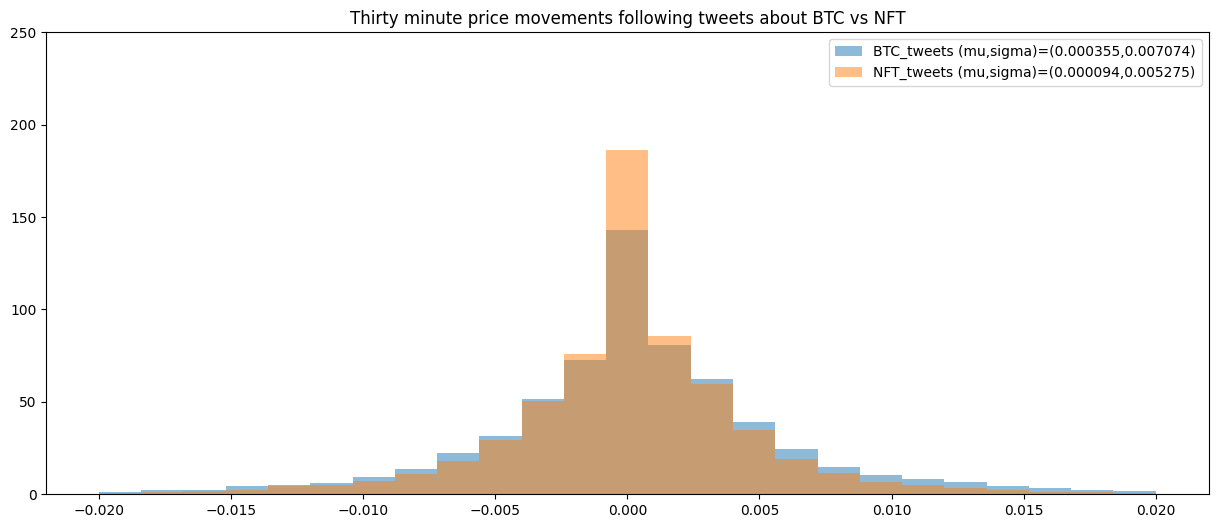

KstestResult(statistic=0.05455999999999994, pvalue=4.006027126408225e-65, statistic_location=0.0026449263055903023, statistic_sign=-1)

In [11]:
xx = x['t30'].np()
yy = y['t30'].np()
bins = np.linspace(-0.02, 0.02, 26)
fig,ax = plt.subplots(1,figsize=(15,6))
ax.hist(xx, bins, alpha=0.5, label=search1 + "_tweets (mu,sigma)=({:.6f},{:.6f})".format(np.mean(xx),np.std(xx)),density=True)
ax.hist(yy, bins, alpha=0.5, label=search2 + "_tweets (mu,sigma)=({:.6f},{:.6f})".format(np.mean(yy),np.std(yy)),density=True)
ax.legend(loc='upper right')
ax.set_title("Thirty minute price movements following tweets about BTC vs NFT")
ax.set_ylim(0,250)
plt.show()
scipy.stats.ks_2samp(xx,yy)

### Plot of expected returns and volatility as various time horizons

To finish up we plot the average returns over intervals of 1 minute, 5 minutes, 15 minutes, 30 minutes and 1 hour. The plot also contains a measure of volatility with the shaded region accounting for one standard deviation in the price.

***The BTC tweets tend to have higher returns but come with greater risk this is seen at all intervals***

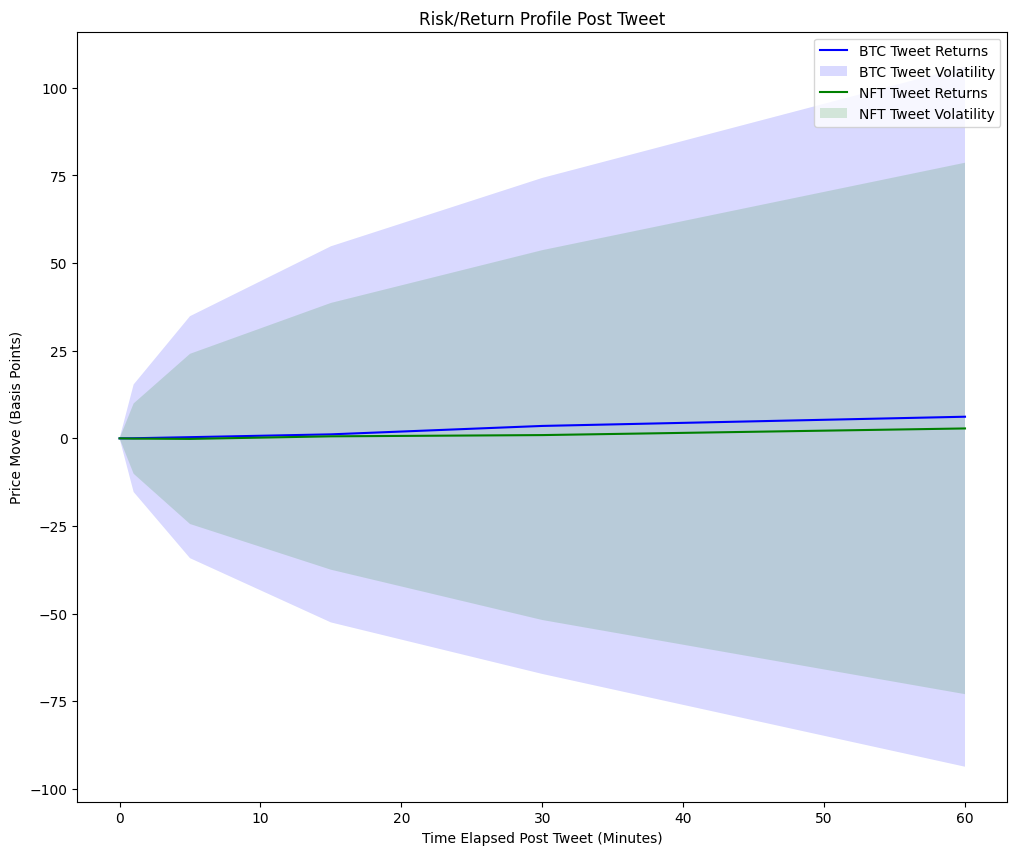

In [35]:
fig,ax = plt.subplots(1,1,figsize=(12,10),)

xxx = kx.q.flip(x.loc[:, ['t1','t5','t15','t30','t60']]).values()
yyy = kx.q.flip(y.loc[:, ['t1','t5','t15','t30','t60']]).values()

m = pd.DataFrame({'btc':[0.0] + kx.q.avg(kx.q.flip(xxx)).py(),
                  'nft':[0.0] + kx.q.avg(kx.q.flip(yyy)).py(),
                  'btcs':[0.0] + kx.q.each(kx.q.dev, xxx).py(),
                  'nfts':[0.0] + kx.q.each(kx.q.dev, yyy).py()},
                  index=[0.0,1.0, 5.0, 15.0, 30.0, 60.0])

ax.plot(m.index, 10000*(m['btc']),color='b',label="BTC Tweet Returns")
ax.fill_between(m.index, 10000*(m['btc']-m['btcs']), 10000*(m['btc']+m['btcs']),facecolor='blue',alpha=0.15,label="BTC Tweet Volatility")
ax.plot(m.index, 10000*(m['nft']),color='g',label="NFT Tweet Returns")
ax.fill_between(m.index, 10000*(m['nft']-m['nfts']), 10000*(m['nft']+m['nfts']),facecolor='green',alpha=0.15,label="NFT Tweet Volatility")
ax.legend()
ax.set_ylabel('Price Move (Basis Points)')
ax.set_xlabel('Time Elapsed Post Tweet (Minutes)')
ax.set_title('Risk/Return Profile Post Tweet')
plt.show()

## Conclusion 

We combined Twitter data and crypto price data, and then used semantic search to analyze the relationship between them.

We found BTC tweets tend to have higher returns that NFT tweets but come with greater risk which was seen at all time intervals.

A next step could be to analyse sentiment in the tweets to see how positive or negative a tweet is affects price. You can find this follow on tutorial here.

---